In [1]:
from pulse_building import Waveform, Element, Sequence
import numpy as np
import copy
%matplotlib nbagg
import matplotlib.pyplot as plt

### General Variables

In [2]:
cycle_duration = 10e-6
resolution = 1e-9
pulse_end = 5e-6

points = round(cycle_duration / resolution)
pulse_end_points = round(pulse_end / resolution)

### Readout Settings

In [54]:
readout_start = pulse_end + 50e-9
readout_time = 4e-6

readout_start_points = round(readout_start / resolution)
readout_points = round(readout_time / resolution)

readout_waveform = Waveform(length=points, channel=3)
readout_waveform.wave[readout_start_points:readout_start_points+readout_points] = 1
readout_waveform.marker_1[pulse_end_points:readout_start_points+10] = 1
readout_waveform.marker_2[pulse_end_points:readout_start_points+10] = 1

## Rabi

In [32]:
rabi_sequence = Sequence(name='rabi',
                         variable='qubit pulse duration',
                         variable_unit='s',
                         step=1e-9,
                         start=0,
                         stop=200e-9)

qubit_duration_array_points = np.round(rabi_sequence.variable_array / resolution).astype(int)

for i, qubit_points in enumerate(qubit_duration_array_points):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_waveform = Waveform(length=points, channel=1)
    if i == 0:
        qubit_waveform.marker_1[0:100] = 1
        qubit_waveform.marker_2[0:100] = 1
    qubit_start = pulse_end_points - qubit_points
    qubit_end = pulse_end_points
    qubit_waveform.wave[qubit_start:qubit_end] = 1
    element.add_waveform(qubit_waveform) 
    rabi_sequence.add_element(element)

rabi_sequence.check()
print(len(rabi_sequence.variable_array))

sequence check passed: 200 elements
200


## T1

In [18]:
t1_sequence = Sequence(name='t1',
                       variable='pi pulse readout delay',
                       variable_unit='s',
                       step=0.5e-6,
                       start=0,
                       stop=20e-6)

qubit_time = 1e-6
qubit_points = round(qubit_time / resolution)
delay_array_points = np.round(t1_sequence.variable_array / resolution).astype(np.int)

for i, delay_points in enumerate(delay_array_points):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_waveform = Waveform(length=points, channel=1)
    if i == 0:
        qubit_waveform.marker_1[0:100] = 1
        qubit_waveform.marker_2[0:100] = 1
    qubit_start = pulse_end_points - delay_points - qubit_points
    qubit_end = pulse_end_points - delay_points
    qubit_waveform.wave[qubit_start:qubit_end] = 1
    element.add_waveform(qubit_waveform) 
    t1_sequence.add_element(element)

t1_sequence.check()

sequence check passed: 41 elements


True

## SSB

In [88]:
ssb_sequence = Sequence(name='ssb',
                       variable=' diff from f0',
                       variable_unit='GHz',
                       step=1e6,
                       start=0,
                       stop=100e6)

qubit_time = 1e-6
qubit_points = round(qubit_time / resolution)
qubit_time_array = np.arange(qubit_points) * resolution
freq_array = ssb_sequence.variable_array

for i, freq in enumerate(freq_array):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_i = Waveform(length=points, channel=1)
    qubit_q = Waveform(length=points, channel=2)
    if i == 0:
        qubit_i.marker_1[0:100] = 1
        qubit_waveform.marker_2[0:100] = 1
    qubit_start = pulse_end_points - qubit_points
    qubit_end = pulse_end_points
    angle = qubit_time_array * freq * 2 * np.pi
    cos_array = np.cos(angle)
    sin_array = np.sin(angle)
    qubit_i.wave[qubit_start:qubit_end] = cos_array
    qubit_q.wave[qubit_start:qubit_end] = sin_array
    element.add_waveform(qubit_i)
    element.add_waveform(qubit_q)
    ssb_sequence.add_element(element)

ssb_sequence.check()

sequence check passed: 101 elements


True

<IPython.core.display.Javascript object>


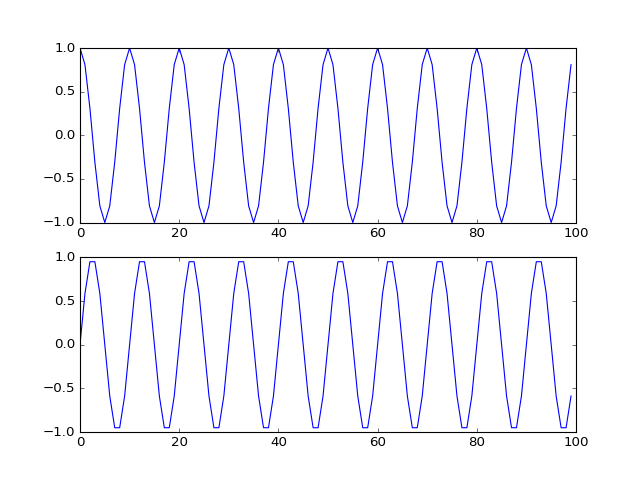

In [89]:
fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(qubit_i.wave[qubit_start:qubit_start+100])
ax2.plot(qubit_q.wave[qubit_start:qubit_start+100])

## Plot Sequence

<IPython.core.display.Javascript object>


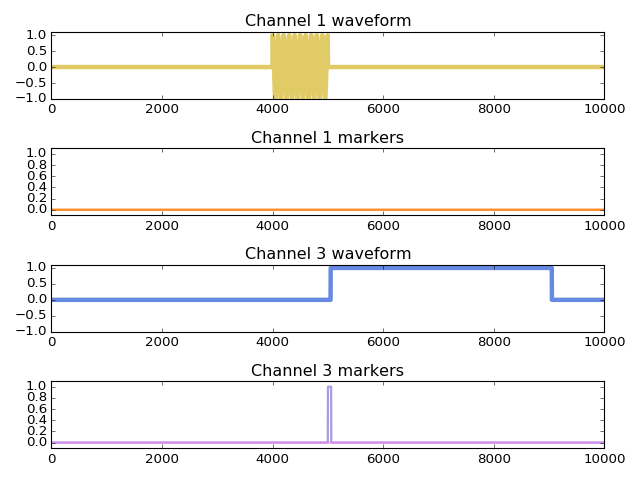

In [53]:
sequence = ssb_sequence # choose which sequence to plot
elemnum = 10 # choose which element to plot
chan_a, chan_b  = 1, 3 # choose which two channels to plot

fig = plt.figure()

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.set_title('Channel {} waveform'.format(chan_a))
ax1.set_ylim([-1, 1.1])
ax2.set_title('Channel {} markers'.format(chan_a))
ax2.set_ylim([-0.1, 1.1])
ax3.set_title('Channel {} waveform'.format(chan_b))
ax3.set_ylim([-1, 1.1])
ax4.set_title('Channel {} markers'.format(chan_b))
ax4.set_ylim([-0.1, 1.1])


ax1.plot(sequence[elemnum][chan_a].wave, lw=4, color='#e1cb66')
ax2.plot(sequence[elemnum][chan_a].marker_1, lw=2, color='#FF4500', alpha=0.6)
ax2.plot(sequence[elemnum][chan_a].marker_2, lw=2, color='#FF8C00', alpha=0.6)

ax3.plot(sequence[elemnum][chan_b].wave, lw=4, color='#6689e1')
ax4.plot(sequence[elemnum][chan_b].marker_1, lw=2, color='#6A5ACD', alpha=0.6)
ax4.plot(sequence[elemnum][chan_b].marker_2, lw=2, color='#EE82EE', alpha=0.6)

plt.tight_layout()

## Upload to AWG

In [90]:
(waveforms, m1s, m2s ,nreps, trig_waits, goto_states, jump_tos) = ssb_sequence.unwrap()

In [7]:
import qcodes.instrument_drivers.tektronix.AWG5014 as awg
awg1 = awg.Tektronix_AWG5014('AWG1', 'TCPIP0::172.20.3.170::inst0::INSTR', timeout=40)

Connected to: TEKTRONIX AWG5014C (serial:B010169, firmware:SCPI:99.0 FW:4.2.0.27) in 0.21s


In [91]:
awg1.make_send_and_load_awg_file(waveforms, m1s, m2s, 
                                 nreps, trig_waits,
                                 goto_states, jump_tos)

In [92]:
awg1.ch1_state(1)
awg1.ch2_state(1)
awg1.ch3_state(1)
awg1.run()

'Running'